In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, utils
import copy
from utils import *
%matplotlib inline

2がblock1_conv2に対応
16がblock3_conv4に対応

In [2]:
image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ])

In [3]:
sample = cv2.imread('sample1.jpg')

In [4]:
image = image_transform(sample).unsqueeze(0)

In [5]:
sample_template = cv2.imread('template1.png')
template = image_transform(sample_template).unsqueeze(0)

In [6]:
class Featex():
    def __init__(self, model, use_cuda):
        self.use_cuda = use_cuda
        self.feature1 = None
        self.feature2 = None
        self.model= copy.deepcopy(model.eval())
        self.model = self.model[:17]
        if self.use_cuda:
            self.model = self.model.cuda()
        self.model[2].register_forward_hook(self.save_feature1)
        self.model[16].register_forward_hook(self.save_feature2)
        
    def save_feature1(self, module, input, output):
        self.feature1 = output.detach()
    
    def save_feature2(self, module, input, output):
        self.feature2 = output.detach()
        
    def __call__(self, input):
        if self.use_cuda:
            input = input.cuda()
        _ = self.model(input)
        # resize feature2 to the same size of feature1
        self.feature2 = F.interpolate(self.feature2, size=(self.feature1.size()[2], self.feature1.size()[3]), mode='bilinear', align_corners=True)
        return torch.cat((self.feature1, self.feature2), dim=1)

In [7]:
def call( self, x ):
        x1, x2 = x
        bs, H, W, _ = [tf.shape(x1)[i] for i in range(4)]
        _, h, w, _ = [tf.shape(x2)[i] for i in range(4)]
        x1 = tf.reshape(x1, ( bs, H*W, -1 ) )
        x2 = tf.reshape(x2, ( bs, h*w, -1 ) )
        concat = tf.concat([x1, x2], axis=1)
        x_mean = K.mean( concat, axis=1, keepdims=True )
        x_std = K.std( concat, axis=1, keepdims = True )
        x1 = (x1 - x_mean) / x_std
        x2 = (x2 - x_mean) / x_std
        x1 = tf.reshape(x1, ( bs, H, W, -1 ) )
        x2 = tf.reshape(x2, ( bs, h, w, -1 ) )
        return [x1, x2]

In [8]:
class MyNormLayer():
    def __call__(self, x1, x2):
        bs, _ , H, W = x1.size()
        _, _, h, w = x2.size()
        x1 = x1.view(bs, -1, H*W)
        x2 = x2.view(bs, -1, h*w)
        concat = torch.cat((x1, x2), dim=2)
        x_mean = torch.mean(concat, dim=2, keepdim=True)
        x_std = torch.std(concat, dim=2, keepdim=True)
        x1 = (x1 - x_mean) / x_std
        x2 = (x2 - x_mean) / x_std
        x1 = x1.view(bs, -1, H, W)
        x2 = x2.view(bs, -1, h, w)
        return [x1, x2]

In [9]:
class CreateModel():
    def __init__(self, alpha, model, use_cuda):
        self.alpha = alpha
        self.featex = Featex(model, use_cuda)
    def __call__(self, template, image):
        T_feat = self.featex(template)
        I_feat = self.featex(image)
        I_feat, T_feat = MyNormLayer()(I_feat, T_feat)
        print(T_feat.size())
        print(I_feat.size())
        dist = torch.einsum("xcab,xcde->xabde", I_feat / torch.norm(I_feat, dim=1, keepdim=True), T_feat / torch.norm(T_feat, dim=1, keepdim=True))
        conf_map = QATM(self.alpha)(dist)
        return conf_map

In [10]:
class QATM():
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, x):
        batch_size, ref_row, ref_col, qry_row, qry_col = x.size()
        print("x", x.size())
        x = x.view(batch_size, ref_row*ref_col, qry_row*qry_col)
        xm_ref = x - torch.max(x, dim=1, keepdim=True)[0]
        conf_ref = F.softmax(self.alpha*xm_ref, dim=1)
        print("conf_ref", conf_ref.size())
        xm_qry = x - torch.max(x, dim=2, keepdim=True)[0]
        conf_qry = F.softmax(self.alpha * xm_qry, dim=2)
        print("conf_qry", conf_qry.size())
        confidence = torch.sqrt(conf_ref * conf_qry)
        conf_values, ind3 = torch.topk(confidence, 1)
        ind1, ind2 = torch.meshgrid(torch.arange(batch_size), torch.arange(ref_row*ref_col))
        ind1 = ind1.flatten()
        ind2 = ind2.flatten()
        ind3 = ind3.flatten()
        if x.is_cuda:
            ind1 = ind1.cuda()
            ind2 = ind2.cuda()
        #indices = torch.stack([ind1, ind2, ind3], dim=1)
        
        print("confidence", confidence.size())
        #print("indices", indices.size())
        #values = confidence.masked_select(indices)
        #values = confidence[indices.tolist()]
        values = confidence[ind1, ind2, ind3]
        print("values", values.size())
        values = torch.reshape(values, [batch_size, ref_row, ref_col, 1])
        return values
    def compute_output_shape( self, input_shape ):
        bs, H, W, _, _ = input_shape
        return (bs, H, W, 1)

In [11]:
model = CreateModel(model=models.vgg19(pretrained=True).features, alpha=25, use_cuda=True)

In [16]:
def run_one_sample(template, sample):
    val = model(template, sample)
    if val.is_cuda:
        val = val.cpu()
    val = val.numpy()
    print(val.shape)
    return val
    # compute geometry average on score map
    val = np.log( val )
    gray = val[0,:,:,0]
    gray = cv2.resize( gray, (image.shape[1], image.shape[0]) )
    score = compute_score( gray, w, h ) 
    score[score>-1e-7] = score.min()
    score = np.exp(score / (h*w)) # reverse number range back after computing geometry average
    
    # plot result
    x, y, w, h = locate_bbox( score, w, h )
    image_plot = cv2.rectangle( image_plot, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2 )
    fig, ax = plt.subplots( 1, 3, figsize=(20, 5) )
    ax[0].imshow(template_plot)
    ax[1].imshow(image_plot)
    
    ax[2].imshow(score, 'jet')
    plt.show()

In [17]:
val = run_one_sample(template, image)

torch.Size([1, 320, 40, 40])
torch.Size([1, 320, 225, 384])
x torch.Size([1, 225, 384, 40, 40])
conf_ref torch.Size([1, 86400, 1600])
conf_qry torch.Size([1, 86400, 1600])
confidence torch.Size([1, 86400, 1600])
values torch.Size([86400])
(1, 225, 384, 1)


In [18]:
val = np.log(val)

In [19]:
gray = val[0,:,:,0]

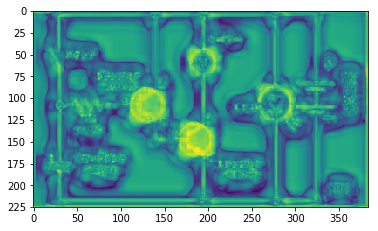

In [26]:
plt.imshow(gray)

In [28]:
template.size()

torch.Size([1, 3, 40, 40])

In [32]:
h = template.size()[-2]
w = template.size()[-1]
score = compute_score(gray, w, h)
score[score>-1e-7] = score.min()
score = np.exp(score / (h*w)) # reverse number range back after computing geometry average

In [34]:
locate_bbox(score, w, h)

(166.0, 127.0, 40, 40)

In [20]:
gray = cv2.resize(gray, (image))

(225, 384)

In [24]:
image.size()

torch.Size([1, 3, 225, 384])

In [17]:
a = torch.rand(2,3,4)

In [ ]:
torch